In [40]:
###############################
# CHANGED to collect roster data previous years, not the current season

## EXAMPLE https://www.collegehockeynews.com/reports/roster/Wisconsin/58/20172018
## EXAMPLE https://www.collegehockeynews.com/reports/roster/Michigan-State/32/20172018


url = 'https://www.collegehockeynews.com/reports/roster/Michigan-State/32'

import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
import re

## Load results for season to get team links
# Read the CSV file
results = pd.read_csv('..\\TEMP\\2020-2021_season.csv')

# Concatenate the unique values in 'Home_Team_Link' and 'Away_Team_Link'
team_links = pd.concat([results['Home_Team_Link'], results['Away_Team_Link']])

# Drop duplicates and NaN values
team_links = team_links.drop_duplicates().dropna()

# Clean up the links - drop everything before the third slash - keep the team name and the school ID as string
team = team_links.str.split('/', expand=True)[3]
# ORIGINAL
number = team_links.str.split('/', expand=True)[4]

# NEW
year = '20202021'
# reconstruct the link and store in a new column
team_links = 'https://www.collegehockeynews.com/reports/roster/' + team + '/' + number + '/' + year

# reset the index
team_links = team_links.reset_index(drop=True)






team_links

# team[0]

# print the first link
# print(team_links[0])

team_links[0]
# results.head()

print(len(team_links))
print(team_links[0])
print(team_links[4])

51
https://www.collegehockeynews.com/reports/roster/Wisconsin/58/20202021
https://www.collegehockeynews.com/reports/roster/Penn-State/60/20202021


In [41]:
# Function to split "Last Team" into "Team" and "League" with edge case handling
def split_last_team(last_team):
    # Use regular expression to extract team and league
    match = re.search(r'(.+) \((.+)\)', last_team)
    if match:
        return match.groups()
    else:
        # If no league is specified, return the team as is and leave league blank
        return last_team, ""

# Updated function to correctly capture the player's position and handle edge cases in "Last Team"
def parse_and_transform_roster(html_content):
    # Initialize BeautifulSoup object
    soup = BeautifulSoup(html_content, 'html.parser')
    
    # Find the table with the roster
    roster_table = soup.find('table', {'id': 'players'})

    # Check if the table exists
    if roster_table is None:
        print("Skipped: The table doesn't exist.")
        return None
    
    # Extract headers
    header_row = roster_table.find('thead').find('tr')
    headers = [header.text.strip() for header in header_row.find_all('th')]
    headers.append('Position')  # Add the Position column to headers
    
    # Initialize data list and current_position variable
    data = []
    current_position = None  # Initialize as None to later filter out irrelevant rows
    
    # Iterate through each row in the table
    for row in roster_table.find_all('tr'):
        if 'class' in row.attrs and 'stats-section' in row.attrs['class']:
            current_position = row.text.strip()
        else:
            cells = row.find_all('td')
            if cells and current_position:
                row_data = [cell.text.strip() for cell in cells]
                row_data.append(current_position)  # Add the current position to the row data
                data.append(row_data)
    
    # Create DataFrame
    df = pd.DataFrame(data, columns=headers)

    # Check if DataFrame is empty or if key columns are missing
    if df.empty or 'Last Team' not in df.columns or 'NHL Draft' not in df.columns:
        print("Skipped: The DataFrame is empty or missing key columns.")
        return None
    
    # Cleanup: Remove rows where 'No.' column is not numeric
    df = df[df['No.'].str.isnumeric()]
    
    # Cleanup: Drop the 'Pos' column
    df.drop(columns=['Pos'], inplace=True)
    
    # Transform Height to Inches
    df['Height_Inches'] = df['Ht.'].apply(convert_to_inches)

    # Transform NHL Draft to Draft_Year, NHL_Team, and D_Round
    # Transform NHL Draft to Draft_Year, NHL_Team, and D_Round
    draft_result = df['NHL Draft'].apply(split_nhl_draft)

    # Check if there are enough values to unpack
    if len(draft_result) > 0:
        df['Draft_Year'], df['NHL_Team'], df['D_Round'] = zip(*draft_result)
    else:
        # Handle the case when result is empty
        df['Draft_Year'], df['NHL_Team'], df['D_Round'] = [None] * len(df), [None] * len(df), [None] * len(df)

    df.drop(columns=['NHL Draft'], inplace=True) # Drop the original NHL Draft column
    
    # Handle edge cases in "Last Team" to split into "Team" and "League"
    df['Team'], df['League'] = zip(*df['Last Team'].apply(split_last_team))
    df.drop(columns=['Last Team'], inplace=True)
    
    # Rename the trouble column Hometown\nLast Team\nNHL Draft
    df.rename(columns={'Hometown\nLast Team\nNHL Draft': 'Hometown'}, inplace=True)

    # assign data types No. Wt. and Height_Inches to int, DOB to datetime
    int_list = ['No.', 'Wt.', 'Height_Inches']
    # Convert columns to numeric, coercing errors to NaN
    df[int_list] = df[int_list].apply(pd.to_numeric, errors='coerce')

    # Replace NaNs with a default value for specific columns
    default_value = 0
    df[int_list] = df[int_list].fillna(value=default_value)

    # Confirm that NaNs are filled
    print(df[int_list].isna().sum())  # Should output all zeros

    # Convert the columns to integers
    df[int_list] = df[int_list].astype(int)

    # df = df[df['Height_Inches'].notna()]  # Assuming convert_to_inches returns None for bad values

    
    return df

# Function to split "NHL Draft" into "Draft_Year", "NHL_Team", and "D_Round"
def split_nhl_draft(nhl_draft):
    try:
        draft_year, nhl_team, d_round = nhl_draft.split('-')
        return draft_year, nhl_team, d_round
    except ValueError:
        # Handle missing or incomplete data
        return None, None, None

# # Test the function
# test_values = ['2022-WSH-7', '', '2021-DET']
# [split_nhl_draft(val) for val in test_values]



# Function to convert height in "ft-in" format to total inches
def convert_to_inches(height_str):
    try:
        feet, inches = map(int, height_str.split('-'))
        return (feet * 12) + inches
    except ValueError:
        return None

In [42]:
## Loop through the team links and parse the roster data 
### Notes: save the roster link to the dataframe and add the team name and school ID

roster_dfs = []  # Assuming this list exists to store each roster DataFrame

# Extract team names from team_links
team_names = pd.Series(team_links).str.split('/', expand=True)[5]

# Loop through each team link
for i, link in enumerate(team_links):
    print(f'Processing team {i+1} of {len(team_links)}')
    
    # Make GET request to team link
    r = requests.get(link)
    html_content = r.text
    
    # Parse and transform the roster data
    roster_df = parse_and_transform_roster(html_content)

    # Check if the DataFrame exists (i.e., the page had content)
    if roster_df is None:
        print(f"Skipping team {i+1} due to missing or empty data.")
        continue  # Skip this iteration and move to the next one



    
    # Reset the index if it's not unique
    roster_df.reset_index(drop=True, inplace=True)
    
    # Add the team name and school ID
    current_team = team_names.iloc[i]  # Extract the current team name
    roster_df['School'] = current_team  # Add it to the DataFrame
    # roster_df['School_ID'] = number[i]  # Assuming number is a list containing school IDs
    # rename Team to Last Team
    roster_df.rename(columns={'Team': 'Last Team'}, inplace=True)
    
    # Add the roster DataFrame to the list
    roster_dfs.append(roster_df)



Processing team 1 of 51


No.              0
Wt.              0
Height_Inches    0
dtype: int64
Processing team 2 of 51
No.              0
Wt.              0
Height_Inches    0
dtype: int64
Processing team 3 of 51
No.              0
Wt.              0
Height_Inches    0
dtype: int64
Processing team 4 of 51
No.              0
Wt.              0
Height_Inches    0
dtype: int64
Processing team 5 of 51
No.              0
Wt.              0
Height_Inches    0
dtype: int64
Processing team 6 of 51
No.              0
Wt.              0
Height_Inches    0
dtype: int64
Processing team 7 of 51
No.              0
Wt.              0
Height_Inches    0
dtype: int64
Processing team 8 of 51
No.              0
Wt.              0
Height_Inches    0
dtype: int64
Processing team 9 of 51
No.              0
Wt.              0
Height_Inches    0
dtype: int64
Processing team 10 of 51
No.              0
Wt.              0
Height_Inches    0
dtype: int64
Processing team 11 of 51
No.              0
Wt.              0
Height_Inches    0
d

In [43]:
####### Check the Resulting DataFrames

# Check the number of DataFrames in the list
print(len(roster_dfs)) 
## Show the head of the first DataFrame
# roster_dfs[0].head()

# Create a single master DataFrame and output a CSV file
master_roster_df = pd.concat(roster_dfs)

# Reset the index
master_roster_df.reset_index(drop=True, inplace=True)

# Output the CSV file
master_roster_df.to_csv('..\\TEMP\\NEW_T_2020_master_roster.csv', index=False)


51


In [44]:
import pandas as pd
#### 
# master_roster_df = pd.read_csv('..\\data\\rosters\\2023_master_roster.csv')

In [45]:
## Examine the master DataFrame

# Check the number of rows and columns
print(master_roster_df.shape)

# Check the data types
print(master_roster_df.dtypes)

# Check the first few rows
master_roster_df.head()

(1462, 16)
                 object
No.               int32
Name             object
Yr.              object
Ht.              object
Wt.               int32
DOB              object
Hometown         object
Position         object
Height_Inches     int32
Draft_Year       object
NHL_Team         object
D_Round          object
Last Team        object
League           object
School           object
dtype: object


,,No.,Name,Yr.,Ht.,Wt.,DOB,Hometown,Position,Height_Inches,Draft_Year,NHL_Team,D_Round,Last Team,League,School
0,,28,"Donovan, Shay",So,6-3,190,5/26/1998,"Duluth, Minn.",Defensemen,75,None,None,None,Wisconsin,B10,Wisconsin
1,,21,"Emberson, Ty (C)",Jr,6-1,198,5/24/2000,"Eau Claire, Wis.",Defensemen,73,2018,ARI,3,USA U-18 Team,NTDP,Wisconsin
2,,20,"Ess, Josh",Sr,5-11,187,4/3/1999,"Lakeville, Minn.",Defensemen,71,2017,CHI,7,Lakeville South,USHS,Wisconsin
3,,5,"Inamoto, Tyler (C)",Sr,6-2,198,5/6/1999,"Barrington, Ill.",Defensemen,74,2017,FLA,5,USA U-18 Team,NTDP,Wisconsin
4,,24,"Kehrer, Anthony",Fr,5-11,196,3/4/2002,"Winnipeg, Man.",Defensemen,71,None,None,None,Sioux City,USHL,Wisconsin


In [46]:
## Valuecounts of Hometown, Last Team, League
master_roster_df['Hometown'].value_counts()

# master_roster_df['Last Team'].value_counts()

# master_roster_df['League'].value_counts()

# Unique Count of Home Towns
master_roster_df['Hometown'].nunique()
# store the unique hometowns in a list
unique_hometowns = master_roster_df['Hometown'].unique()

# 

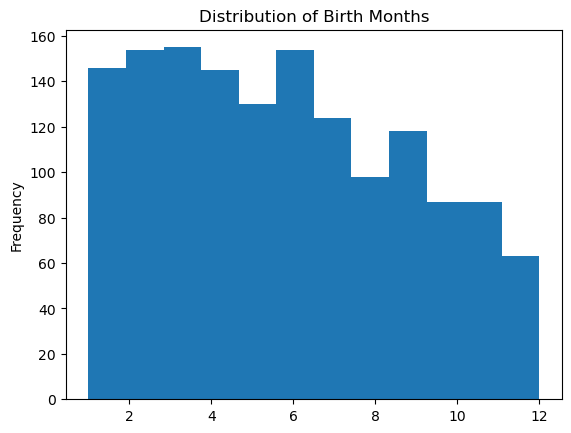

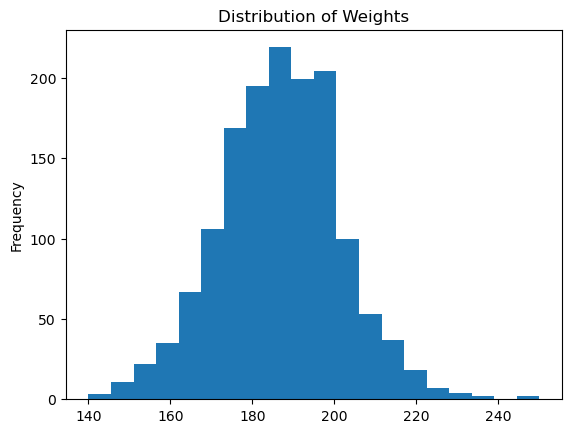

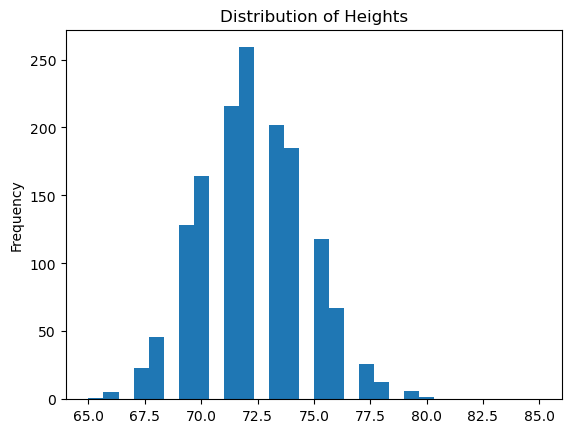

In [47]:
import matplotlib as plt
import matplotlib.pyplot as plt

## Show the ditrobution of birthdates by month

# make sure the DOB column is a datetime
master_roster_df['DOB'] = pd.to_datetime(master_roster_df['DOB'])
# Extract the month from the DOB column
master_roster_df['Month'] = master_roster_df['DOB'].dt.month

# Plot the distribution of months
master_roster_df['Month'].plot.hist(bins=12, title='Distribution of Birth Months')
# show the plot
plt.show()

## Show the distribution of weights
master_roster_df['Wt.'].plot.hist(bins=20, range=(140,250), title='Distribution of Weights')
# show the plot
plt.show()

# Show the distribution of heights with range of 60 to 90 inches
master_roster_df['Height_Inches'].plot.hist(bins=30, range=(65, 85), title='Distribution of Heights')
# show the plot
plt.show()



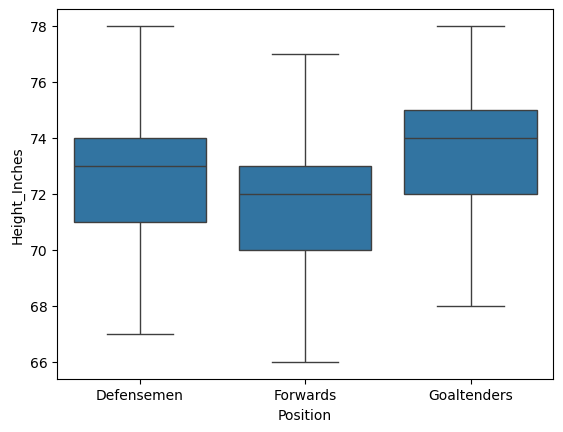

In [48]:
### Create a Box Plot of Height by Position # y range is 65 to 90
import seaborn as sns

box_data = master_roster_df

# filter to the
# create a boxplot of height by position - limit the y range to 65 to 90

sns.boxplot(x='Position', y='Height_Inches', data=box_data, showfliers=False)








# show the plot
plt.show()

C:\Users\Justin\AppData\Local\Temp\ipykernel_8048\307841344.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = master_roster_df.groupby('Height_Bins')['Wt.'].apply(list)


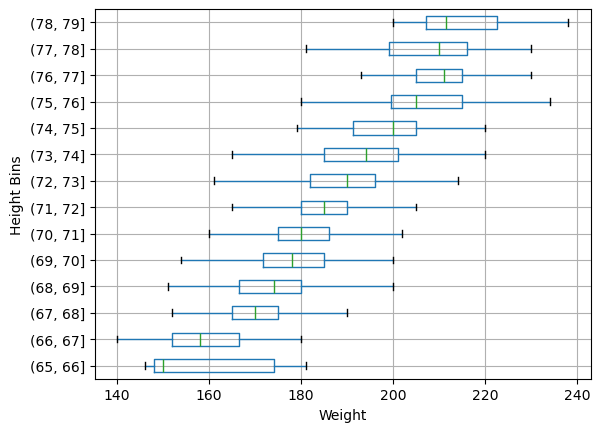

In [49]:
import matplotlib.pyplot as plt

## BIN PLAYERS BY HEIGHT AND SHOW THE DISTRIBUTION OF WEIGHTS IN EACH BIN

# Create the bins
master_roster_df['Height_Bins'] = pd.cut(master_roster_df['Height_Inches'], bins=range(65, 80, 1))

# Group by bins and make lists of weights in each bin
grouped = master_roster_df.groupby('Height_Bins')['Wt.'].apply(list)

# Create a new DataFrame where each row corresponds to a bin
# and each entry in the row is a weight from that bin
df2 = pd.DataFrame({name: pd.Series(data) for name, data in grouped.items()})

# Now you can create a horizontal boxplot
df2.boxplot(showfliers=False, vert=False)
plt.xlabel('Weight')
plt.ylabel('Height Bins')
plt.show()


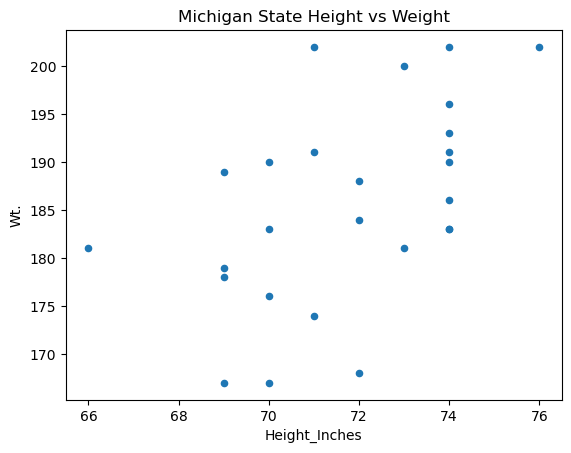

In [50]:
## Create a scatter plot of height vs weight just for Michigan State
# Filter the DataFrame to just Michigan State
msu_df = master_roster_df[master_roster_df['School'] == 'Michigan-State']

# Create the scatter plot
msu_df.plot.scatter(x='Height_Inches', y='Wt.', title='Michigan State Height vs Weight')
# show the plot
plt.show()

In [51]:
##############

BRAKE


NameError: name 'BRAKE' is not defined

In [ ]:
######### Simple Map of Hometowns

from geopy.geocoders import Nominatim
import geopandas as gpd
import matplotlib.pyplot as plt

df = master_roster_df

# Initialize geocoder
geolocator = Nominatim(user_agent="hockey_hometowns")

# Geocode hometowns to get latitude and longitude - try then continue if error
try:
    df['Coordinates'] = df['Hometown'].apply(geolocator.geocode).apply(lambda loc: tuple(loc.point) if loc else None)
except:
    pass

# Split coordinates into latitude and longitude
df[['Latitude', 'Longitude', '_']] = pd.DataFrame(df['Coordinates'].tolist(), index=df.index)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))


In [ ]:
## save the geodataframe to a shapefile for use in QGIS
gdf.to_file('..\\TEMP\\2023_master_roster_with coordinates.shp')
